In [1]:
!pip install pygimli tetgen


# Raypaths in layered and gradient models

This example performs raytracing for a two-layer and a vertical gradient model
and compares the resulting traveltimes to existing analytical solutions. An
approximation of the raypath is found by finding the shortest-path through a
grid of nodes. The possible angular coverage is small when only corner points
of a cell (primary nodes) are used for this purpose. The angular coverage, and
hence the numerical accuracy of traveltime calculations, can be significantly
improved by a few secondary nodes along the cell edges. Details can be found in
[Giroux & Larouche (2013)](https://doi.org/10.1016/j.cageo.2012.12.005).


In [2]:
from math import asin, tan

import matplotlib.pyplot as plt
import numpy as np
import pygimli as pg
import pygimli.meshtools as mt
from pygimli.viewer.mpl import drawMesh

from pygimli.physics import TravelTimeManager

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Two-layer model
We start by building a regular grid.



In [3]:
mesh_layered = mt.createGrid(
    np.arange(-20, 155, step=5, dtype=float), np.linspace(-60, 0, 13))

We now construct the velocity vector for the two-layer case by iterating over
the cells. Cells above 25 m depth are assigned $v = 1000$ m/s and cells
below are assigned $v = 3000$ m/s.



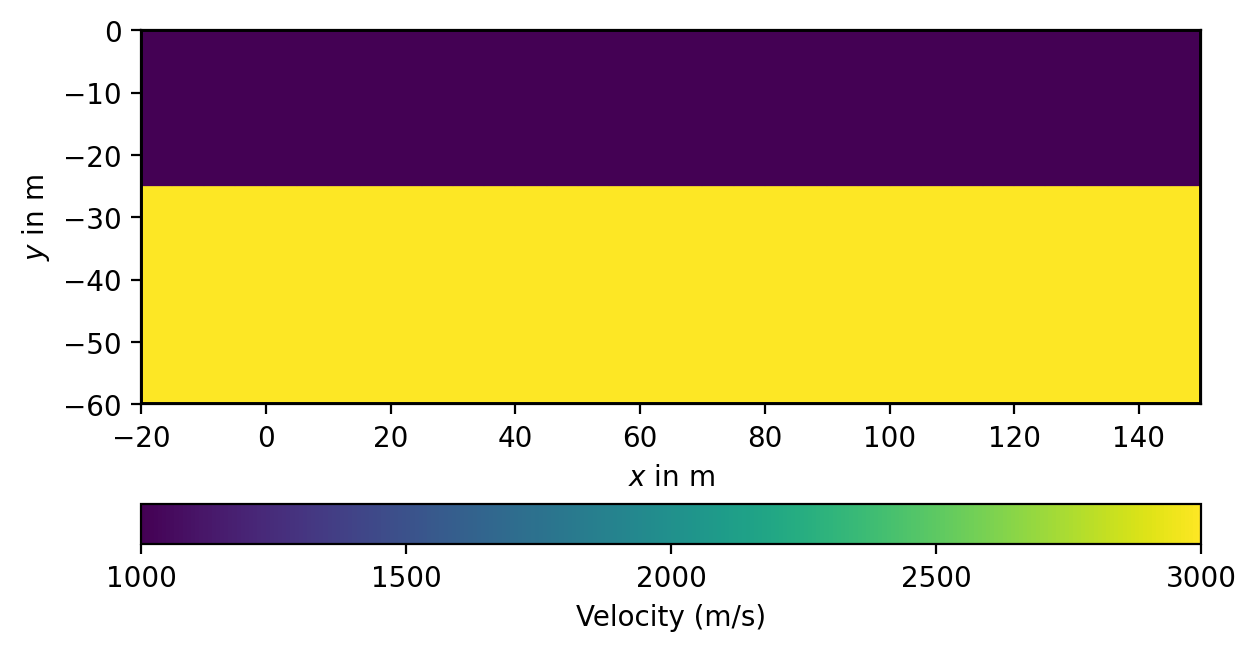

In [4]:
vel_layered = np.zeros(mesh_layered.cellCount())
for cell in mesh_layered.cells():
    if cell.center().y() < -25:
        vel = 3000.0
    else:
        vel = 1000.0
    vel_layered[cell.id()] = vel

ax, cb = pg.show(mesh_layered, vel_layered, label="Velocity (m/s)")

We now define the analytical solution. The traveltime at a given offset `x`
is the minimum of the direct and critically refracted wave, where the latter
is governed by Snell's law.



In [5]:
def analyticalSolution2Layer(x, zlay=25, v1=1000, v2=3000):
    """Analytical solution for 2 layer case."""
    tdirect = np.abs(x) / v1  # direct wave
    alfa = asin(v1 / v2)  # critically refracted wave angle
    xreflec = tan(alfa) * zlay * 2.  # first critically refracted
    trefrac = (x - xreflec) / v2 + xreflec * v2 / v1**2
    return np.minimum(tdirect, trefrac)

## Vertical gradient model
We first create an unstructured mesh:



In [6]:
sensors = np.arange(131, step=10.0)
plc = mt.createWorld([-20, -60], [150, 0], worldMarker=False)
for pos in sensors:
    plc.createNode([pos, 0.0])
mesh_gradient = mt.createMesh(plc, quality=33, area=3)

A vertical gradient model, i.e. $v(z) = a + bz$, is defined per cell.



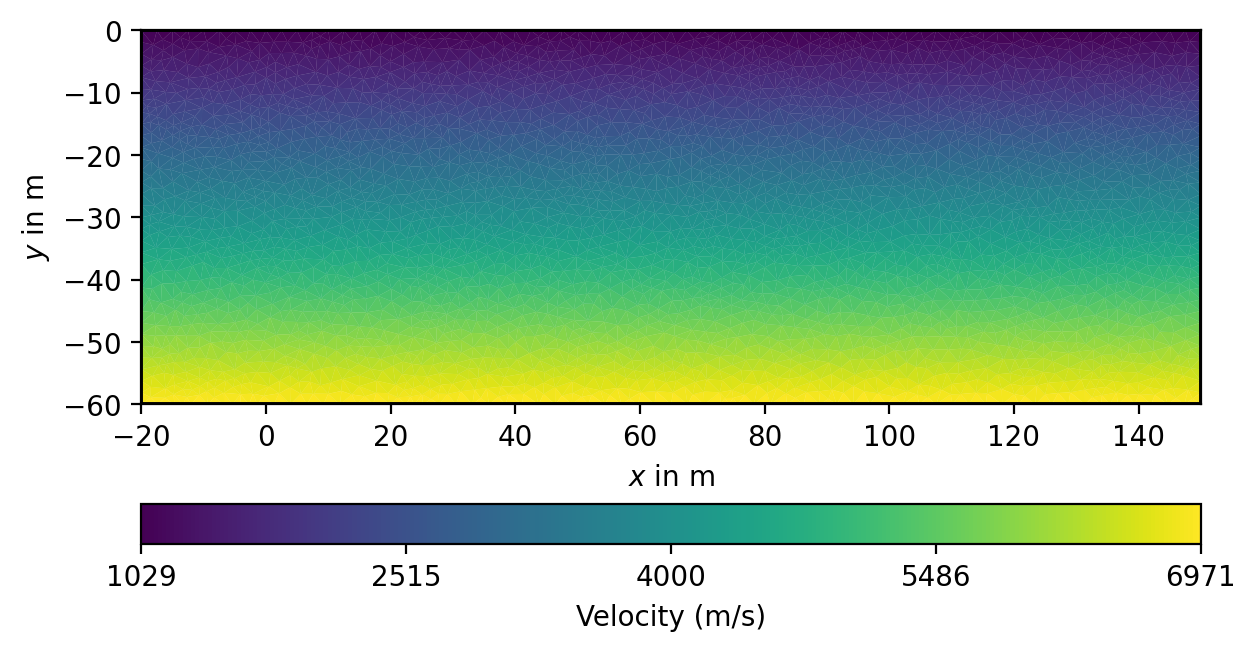

In [7]:
a = 1000
b = 100

vel_gradient = []
for node in mesh_gradient.nodes():
    vel_gradient.append(a + b * abs(node.y()))
vel_gradient = pg.meshtools.nodeDataToCellData(mesh_gradient,
                                               np.array(vel_gradient))
ax, cb = pg.show(mesh_gradient, vel_gradient, label="Velocity (m/s)")

The traveltime for a gradient velocity model is given by:

\begin{align}v = \left|b^{-1}cosh^{-1}\left(1 + \frac{b^2 x^2}{2a^2}\right)\right|\end{align}




In [8]:
def analyticalSolutionGradient(x, a=1000, b=100):
    """Analytical solution for gradient model."""
    tdirect = np.abs(x) / a  # direct wave
    tmp = 1 + ((b**2 * np.abs(x)**2) / (2 * a**2))
    trefrac = np.abs(b**-1 * np.arccosh(tmp))
    return np.minimum(tdirect, trefrac)

The loop below calculates the travel times and makes the comparison plot.



################################################################################
#                                   layered                                    #
################################################################################


INFO:pyGIMLi:Creating refined mesh (secnodes: 1) to solve forward task.
29/10/25 - 07:54:09 - pyGIMLi - INFO - Creating refined mesh (secnodes: 1) to solve forward task.
INFO:pyGIMLi:Creating refined mesh (secnodes: 5) to solve forward task.
29/10/25 - 07:54:10 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.


Raytracing with 0 secondary nodes: Elapsed time is 0.01 seconds.
Raytracing with 1 secondary nodes: Elapsed time is 0.04 seconds.
Raytracing with 5 secondary nodes: Elapsed time is 0.62 seconds.
################################################################################
#                                   gradient                                   #
################################################################################


INFO:pyGIMLi:Creating refined mesh (secnodes: 1) to solve forward task.
29/10/25 - 07:54:12 - pyGIMLi - INFO - Creating refined mesh (secnodes: 1) to solve forward task.


Raytracing with 0 secondary nodes: Elapsed time is 0.13 seconds.
Raytracing with 1 secondary nodes: Elapsed time is 0.58 seconds.


INFO:pyGIMLi:Creating refined mesh (secnodes: 5) to solve forward task.
29/10/25 - 07:54:13 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.


Raytracing with 5 secondary nodes: Elapsed time is 3.07 seconds.


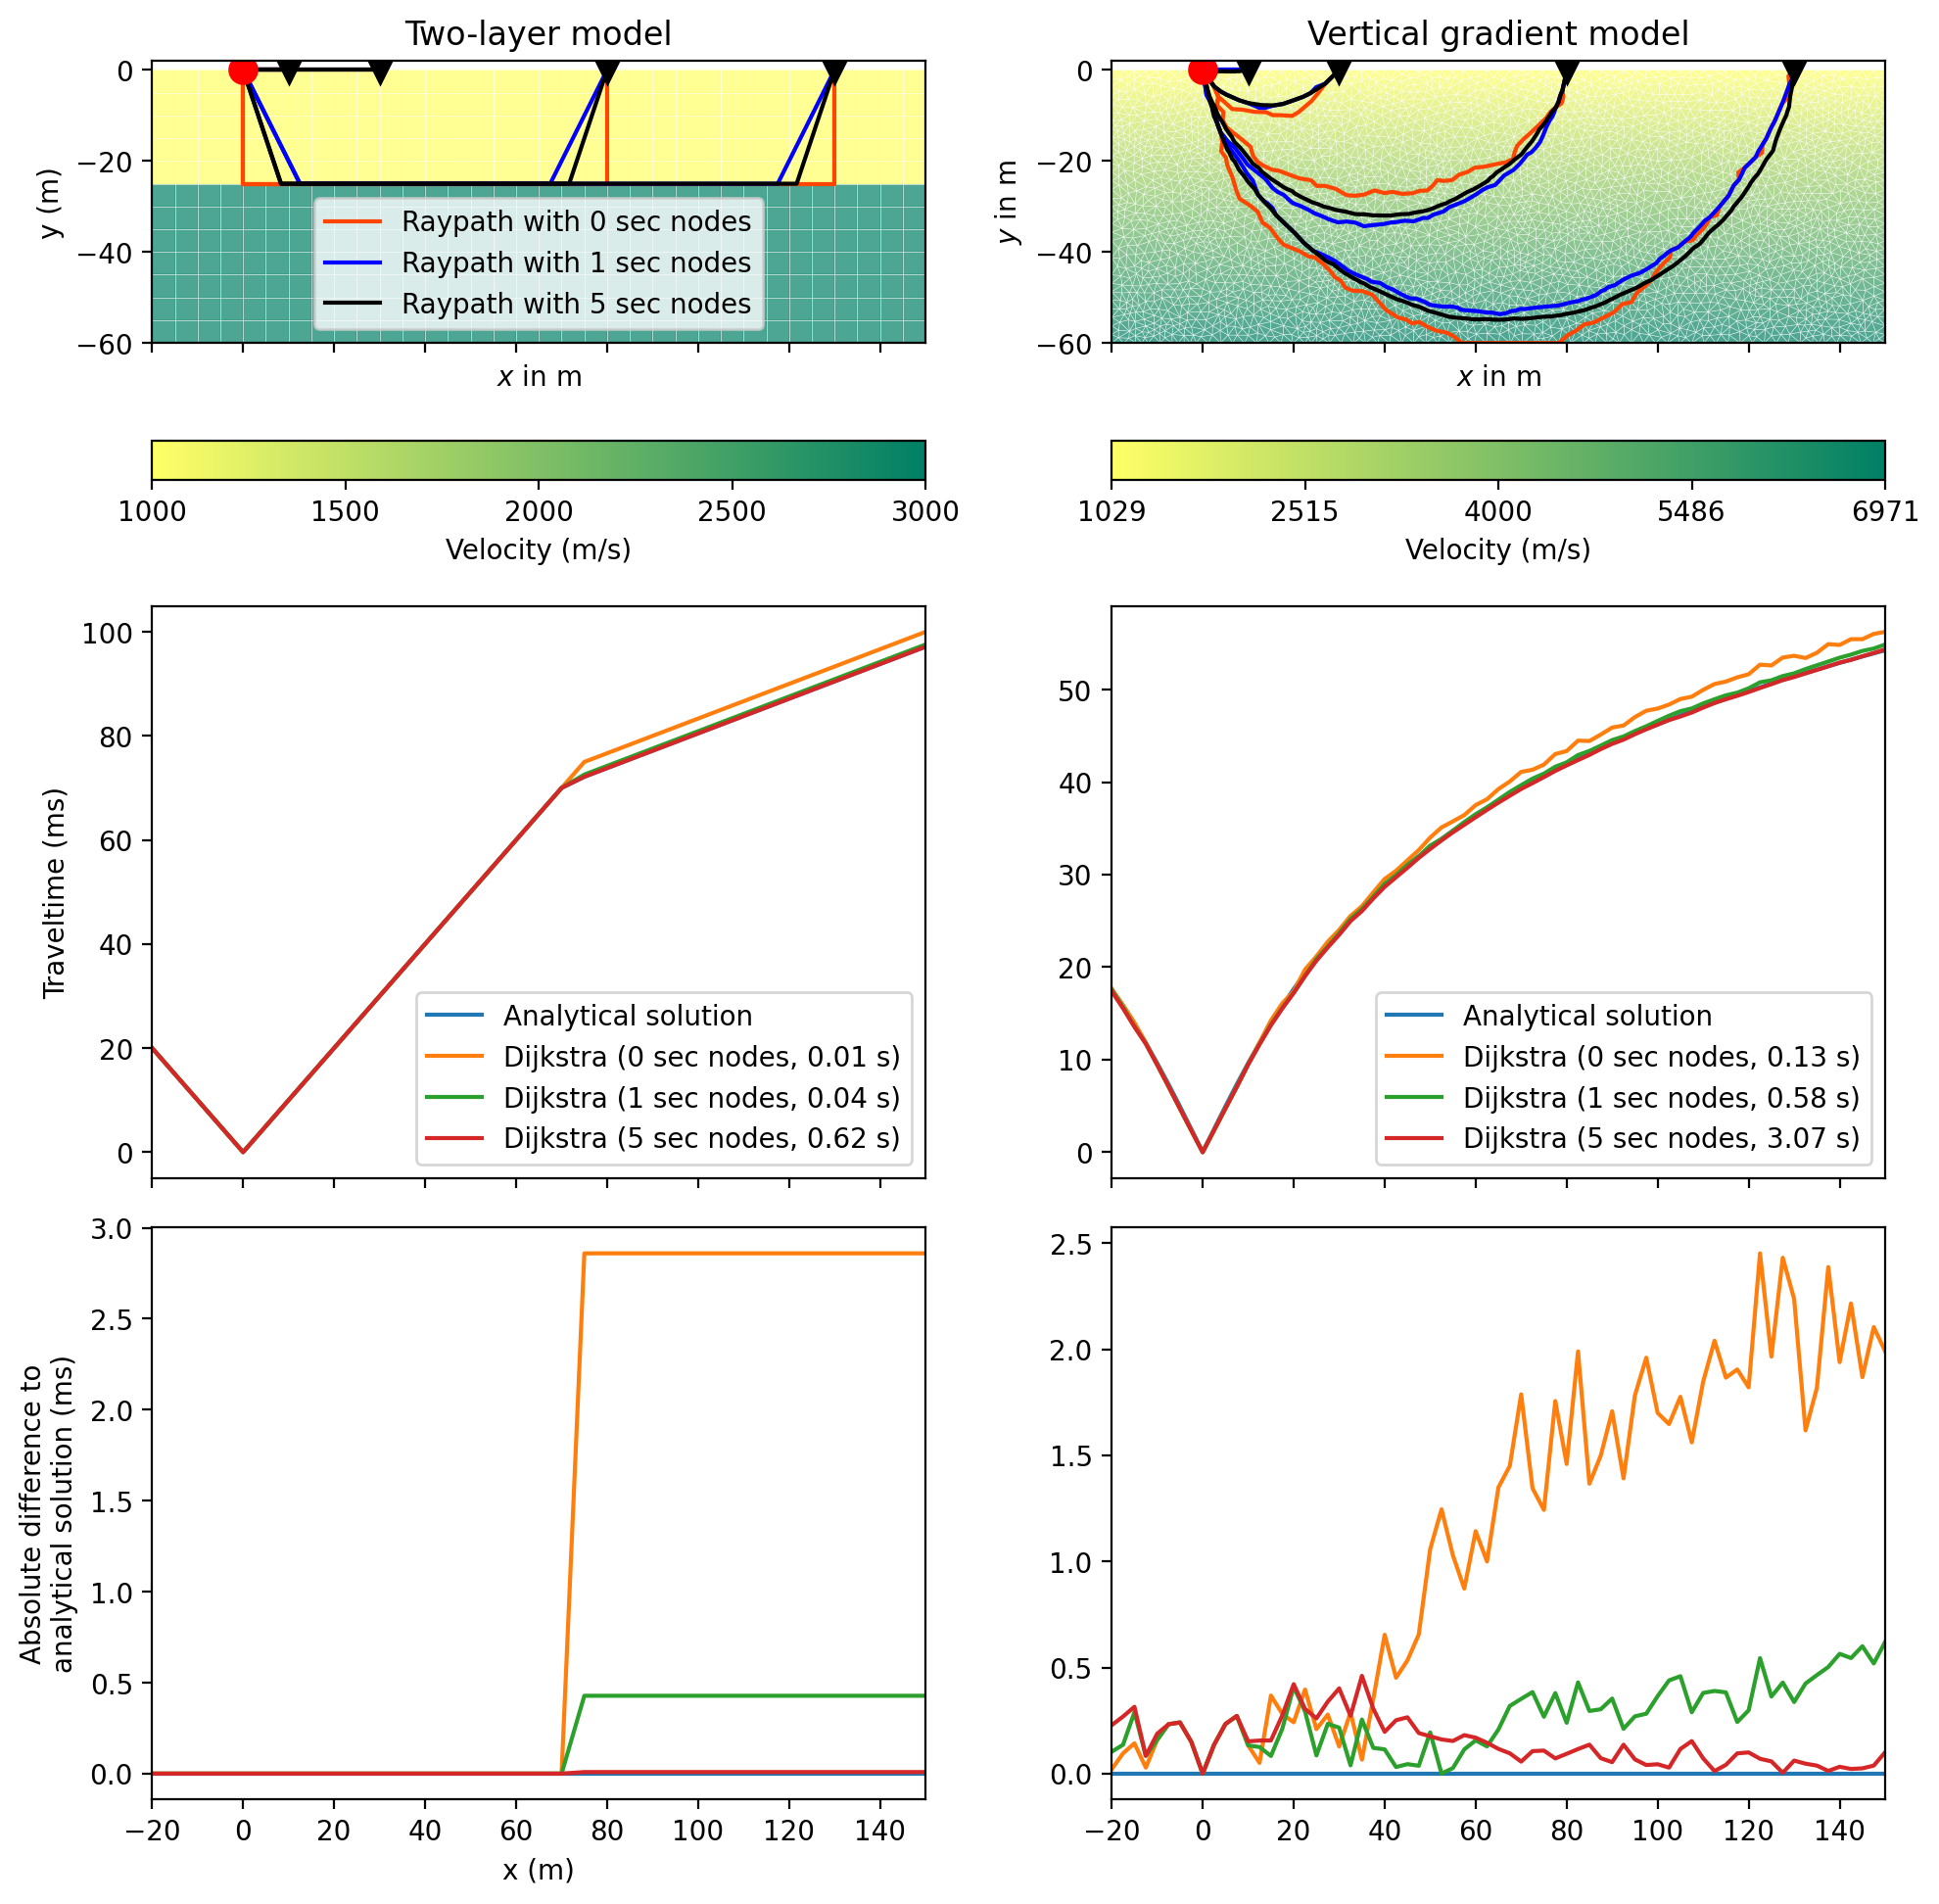

In [9]:
fig, ax = plt.subplots(3, 2, figsize=(10, 10), sharex=True)

for j, (case, mesh, vel) in enumerate(zip(["layered", "gradient"],
                                          [mesh_layered, mesh_gradient],
                                          [vel_layered, vel_gradient])):
    pg.boxprint(case)
    if case == "gradient":
        ana = analyticalSolutionGradient
    elif case == "layered":
        ana = analyticalSolution2Layer
    for boundary in mesh.boundaries():
        boundary.setMarker(0)

    xmin, xmax = mesh.xmin(), mesh.xmax()
    mesh.createNeighborInfos()

    # In order to use the Dijkstra, we extract the surface positions >0
    mx = pg.x(mesh)
    my = pg.y(mesh)
    px = np.sort(mx[my == 0.0])

    # A data container with index arrays named s (shot) and g (geophones) is
    # created and filled with the positions and shot/geophone indices.
    data = pg.DataContainer()
    data.registerSensorIndex('s')
    data.registerSensorIndex('g')

    for i, pxi in enumerate(px):
        data.createSensor([pxi, 0.0])
        if pxi == 0.0:
            source = i

    nData = len(px)
    data.resize(nData)
    data['s'] = [source] * nData # only one shot at first sensor
    data['g'] = range(nData)  # and all sensors are receiver geophones

    # Draw initial mesh with velocity distribution
    pg.show(mesh, vel, ax=ax[0, j], label="Velocity (m/s)", hold=True,
            logScale=False, cMap="summer_r", coverage=0.7)
    drawMesh(ax[0, j], mesh, color="white", lw=0.21)

    # We compare the accuracy for 0-5 secondary nodes
    sec_nodes = [0, 1, 5]
    t_all = []
    durations = []
    paths = []

    mgr = TravelTimeManager()

    cols = ["orangered", "blue", "black"]
    recs = [1, 3, 8, 13]

    for i, n in enumerate(sec_nodes):

        # Perform traveltime calculations and log time with pg.tic() & pg.toc()
        pg.tic()
        res = mgr.simulate(vel=vel, scheme=data, mesh=mesh, secNodes=n)
        # We need to copy res['t'] here because res['t'] is a reference to
        # an array in res, and res will be removed in the next iteration.
        # Unfortunately, we don't have any reverence counting for core objects yet.
        t_all.append(res['t'].array())
        durations.append(pg.dur())
        pg.toc("Raytracing with %d secondary nodes:" % n)

        for r, p in enumerate(recs):
            if r == 0:
                lab = "Raypath with %d sec nodes" % n
            else:
                lab = None

            recNode = mgr.fop.mesh().findNearestNode([sensors[p], 0.0])
            sourceNode = mgr.fop.mesh().findNearestNode([0.0, 0.0])

            path = mgr.fop.dijkstra.shortestPath(sourceNode, recNode)
            points = mgr.fop.mesh().positions(withSecNodes=True)[path].array()
            ax[0, j].plot(points[:,0], points[:,1], cols[i], label=lab)

    t_ana = ana(px)

    # Upper subplot
    ax[1, j].plot(px, t_ana * 1000, label="Analytical solution")

    for i, n in enumerate(sec_nodes):
        ax[1, j].plot(px, t_all[i] * 1000,
                      label="Dijkstra (%d sec nodes, %.2f s)" % (n, durations[i]))

    ax[2, j].plot(px, np.zeros_like(px), label="Zero line")  # to keep color cycle

    for i, n in enumerate(sec_nodes):
        ax[2, j].plot(px, np.abs(t_all[i] - t_ana) * 1000)

    ax[1, j].legend()

    # Draw sensor positions for the selected receivers
    for p in recs:
        ax[0, j].plot(sensors[p], 0.0, "kv", ms=10)
    ax[0, j].plot(0.0, 0.0, "ro", ms=10)
    ax[0, j].set_ylim(mesh.ymin(), 2)

ax[0, 0].set_title("Two-layer model")
ax[0, 1].set_title("Vertical gradient model")
ax[0, 0].legend()
ax[0, 0].set_ylabel("y (m)")
ax[1, 0].set_ylabel("Traveltime (ms)")
ax[2, 0].set_ylabel("Absolute difference to\nanalytical solution (ms)")
ax[2, 0].set_xlabel("x (m)")
fig.tight_layout()